# Building a Vector Database in DuckDB


## Section 1: Setup and Configuration
### Overview
In this section, we're setting up the infrastructure needed to build a vector database.

### 1.1 Installing Libraries
1. `docling`: Document processing library
    - Extracts text and structure from various document formats (PDFs, Word docs, etc.)
    - Handles the messy work of parsing different file types into clean text
    - Think of it as a universal document reader

2. `sentence-transformers`: Creates vector embeddings
    - Converts text into numerical vectors (arrays of numbers)
    - These vectors capture semantic meaning—similar meanings = similar vectors
    - We'll use the model specified in our config to do this conversion

3. `duckdb`: Our vector database engine
    - A lightweight, fast, embedded database (like SQLite but with analytical superpowers)
    - Supports vector similarity search through extensions
    - No separate server needed because it's just a file!

In [1]:
# Installing packages
!pip install -q docling sentence-transformers duckdb

In [2]:
# Mount Google Drive
from google.colab import drive, userdata
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 File Path and Database Configuation

1. **`DATABASE_PATH`**
    - Where the DuckDB database file will be created/stored
    - The database is just a single file (we'll see it after running the pipeline)

2. **`DOCUMENTS_FOLDER`**
    - Location of the source documents we want to process
    - The pipeline will scan this folder for files matching our `FILE_TYPES`

3. **`COLLECTION_NAME`**
    - A label for this particular set of documents in the database
    - Useful if you want multiple collections in one database
    - Name it descriptively for your own project

4. **`FILE_TYPES`**
    - A list of file extensions we want to process
    - Docling can handle all of these formats
    - If you only want PDFs, you could change this to ['.pdf']

5. **`EMBEDDING_MODEL`**
    - Specifies which sentence-transformer model to use `all-MiniLM-L6-v2` is recommended because:
        - Fast: Small model (80MB), processes quickly
        - Good quality: Produces 384-dimensional vectors with good semantic understanding
        - Balanced: Great trade-off between speed and accuracy
        - Popular: Well-tested and documented

Other embedding model options (if you want to experiment)
- `all-mpnet-base-v2`: Higher quality (768 dims), but slower
- `paraphrase-multilingual-MiniLM-L12-v2`: For non-English text


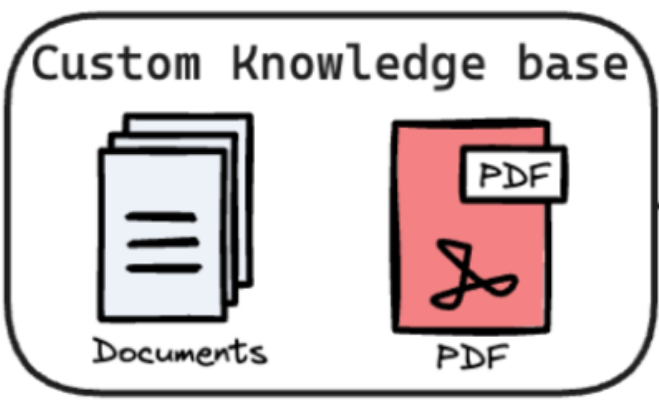

In [3]:
# CHANGE ALL OF THESE TO YOUR OWN!!!!!!!
# Where to store the database (in your Google Drive)
DATABASE_PATH = "/content/drive/Shareddrives/# MDSC-30801-Language-Processing-in-Practice/Fall 2025/Week 12/Chronicles_VectorDB"

# Where your documents are located
DOCUMENTS_FOLDER = "/content/drive/Shareddrives/# MDSC-30801-Language-Processing-in-Practice/Fall 2025/Week 12/Chronicles_Articles_PDFs"

# Collection name
COLLECTION_NAME = "chr_rag_documents"

# File types to process
FILE_TYPES = ['.pdf', '.txt', '.md', '.docx', '.html', '.json']

EMBEDDING_MODEL = "all-MiniLM-L6-v2"  # Fast, good quality (recommended)

## Section 2: Pipeline Initialization and Setup
### Overview

This section does the heavy lifting of setting up all the components we need. Think of it as assembling your tools and preparing your workspace before you start the actual work. We're initializing three key systems: document conversion, text chunking, and the vec

### 2.1 Initialize Chunking Strategy and Objects
- `max_tokens = 512`: Model's input limit (≈380 words)
- `HybridChunker`: Splits at semantic boundaries (paragraphs, sentences)

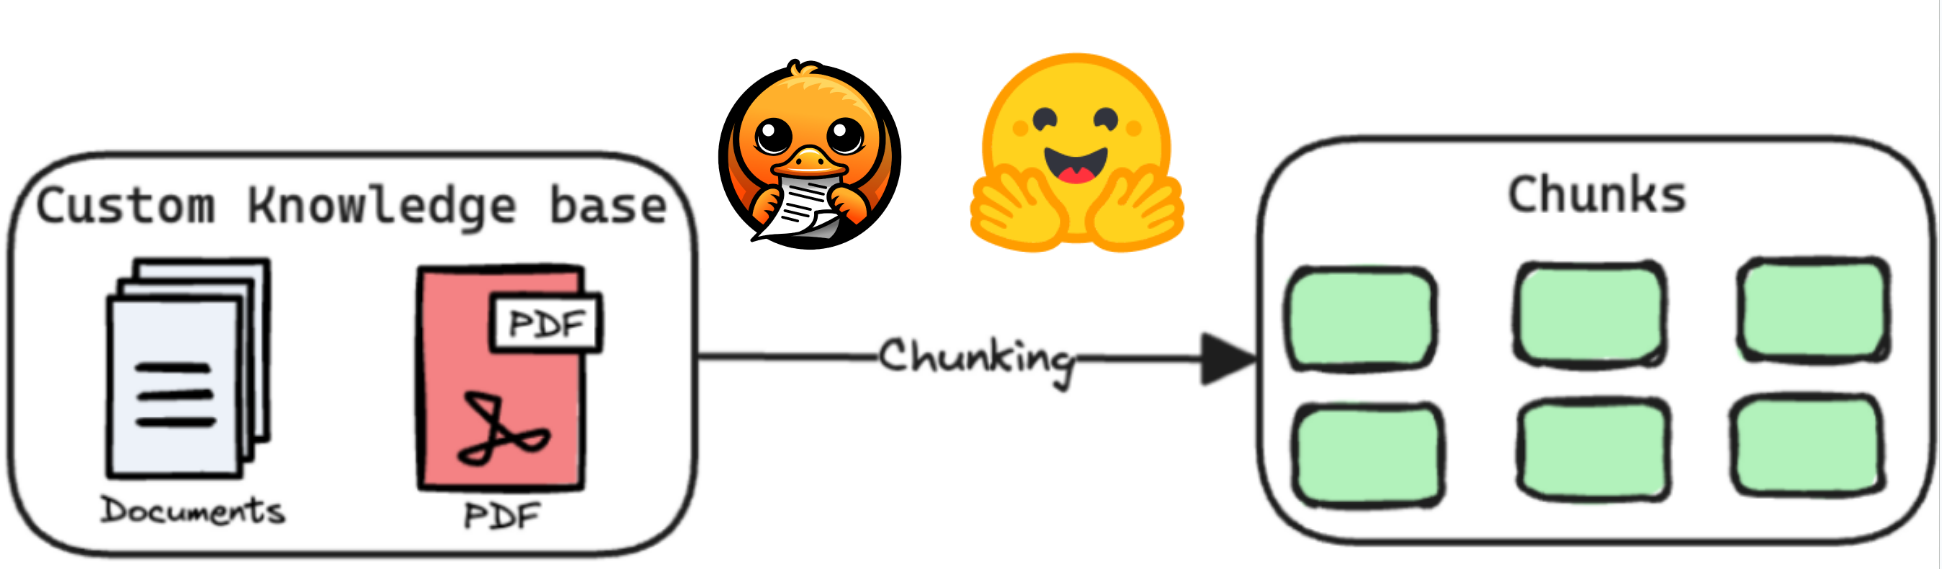

In [4]:
from pathlib import Path
from typing import List
import duckdb
from docling.document_converter import DocumentConverter
from docling.chunking import HybridChunker
from docling_core.transforms.chunker.tokenizer.huggingface import HuggingFaceTokenizer
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
from datetime import datetime

# Initialize document converter
# Handles PDF, DOCX, HTML, MD, TXT extraction
converter = DocumentConverter()

# Initialize chunker with tokenizer
# HybridChunker breaks documents at semantic/structural boundaries
tokenizer = HuggingFaceTokenizer(
    tokenizer=AutoTokenizer.from_pretrained(f"sentence-transformers/{EMBEDDING_MODEL}"),
    max_tokens=512,  # Model's maximum input size
)

chunker = HybridChunker(tokenizer=tokenizer)

# Find all files
folder = Path(DOCUMENTS_FOLDER)
files_to_process = []
for ext in FILE_TYPES:
    files_to_process.extend(folder.glob(f"**/*{ext}"))

print(f"Found {len(files_to_process)} files to process\n")

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Found 3 files to process



### 2.2 Initialize DuckDB Vector Database

- Database directory created (if doesn't exist)
- DuckDB file created/connected: `chronicles_vector.duckdb`
- Vector similarity search (VSS) extension installed and loaded
- Table created with vector-ready schema
- Confirmation printed with database location

**Table Schema:**
- `id VARCHAR PRIMARY KEY`: Unique identifier (prevents duplicate chunks)
- `text VARCHAR`: The actual chunk content
- `embedding FLOAT[384]`: Vector representation
    - • 384 dimensions matches all-MiniLM-L6-v2 output
    - • Change to `FLOAT[768]` if using all-mpnet-base-v2
- `filename VARCHAR`: Source file name for reference
- `source VARCHAR`: Full file path (useful for re-processing)
- `chunk_index INTEGER`: Position in original document (0, 1, 2...)
- `timestamp VARCHAR`: When this chunk was processed

**VSS Extension:**
- Adds vector similarity search capabilities to DuckDB
- Enables functions: array_cosine_similarity(), array_distance(), etc.
- Must INSTALL once (downloads extension), then LOAD each session

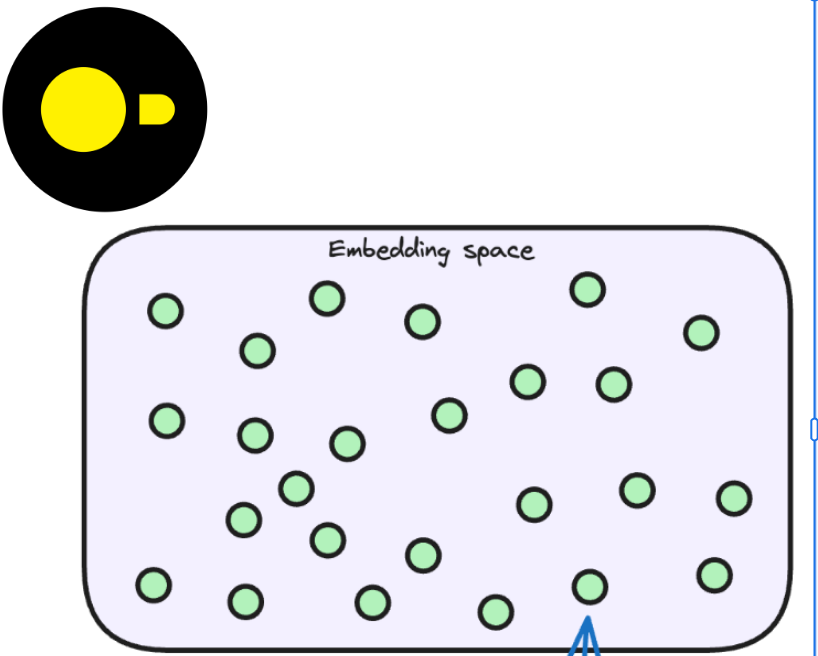

In [5]:
# Set up DuckDB database
db_path = Path(DATABASE_PATH)
db_path.mkdir(parents=True, exist_ok=True)  # Create folder if needed
db_file = db_path / "chronicles_vector.duckdb"

# Connect and enable vector operations
conn = duckdb.connect(str(db_file))
conn.execute("INSTALL vss;")  # Vector Similarity Search extension
conn.execute("LOAD vss;")

# Create table for embeddings
# FLOAT[384] matches all-MiniLM-L6-v2's output dimensions
conn.execute(f"""
    CREATE TABLE IF NOT EXISTS {COLLECTION_NAME} (
        id VARCHAR PRIMARY KEY,      -- Unique chunk identifier
        text VARCHAR,                -- Actual text content
        embedding FLOAT[384],        -- Vector representation
        filename VARCHAR,            -- Source file name
        source VARCHAR,              -- Full file path
        chunk_index INTEGER,         -- Chunk number in document
        timestamp VARCHAR            -- Processing timestamp
    )
""")

print(f"✓ Setup complete")
print(f"  - Database: {db_file}")
print(f"  - Table: {COLLECTION_NAME}\n")

✓ Setup complete
  - Database: /content/drive/Shareddrives/# MDSC-30801-Language-Processing-in-Practice/Fall 2025/Week 12/Chronicles_VectorDB/chronicles_vector.duckdb
  - Table: chr_rag_documents



## Section 3: Document Processing and Chunking
**What Happens:**
1. Loop through each discovered file
2. Convert document to structured format (Docling)
3. Split into semantic chunks (HybridChunker)
4. Add context to each chunk for standalone clarity
5. Store chunk with metadata (filename, source, index, timestamp)
6. Print progress for each file
7. Continue to next file (even if one fails)
8. Report total chunks created

Key Operations:
- `converter.convert(file_path)`:
    - Extracts text from document (PDF, DOCX, etc.)
    - Preserves document structure (headings, paragraphs, lists)
    - Returns a result object with structured document

- `chunker.chunk(result.document)`:
    - Splits document into chunks respecting:
        - Token limits (512 max)
        - Semantic boundaries (paragraphs, sentences)
        - Document structure (sections, headings)
    - Returns iterator of chunk objects

- `chunker.contextualize(chunk=chunk)`:
    - Adds context around the chunk for better standalone understanding
    - Example without context: "This approach works well."
    - Example with context: "Chronicles authorship analysis: This approach works well."
    - Makes chunks more meaningful when retrieved individually

- Error Handling:
    - `try/except` catches failures (corrupted PDFs, unsupported formats)
    - Pipeline continues processing other files
    - Failed files reported but don't stop entire process

In [6]:
from datetime import datetime

# Process each file
all_chunks = []
for file_path in files_to_process:
    print(f"📄 Processing: {file_path.name}")

    try:
        # Convert document to structured format
        # Docling extracts text while preserving structure (headings, paragraphs, etc.)
        result = converter.convert(file_path)

        # Split document into semantic chunks
        # Returns iterator of chunk objects
        chunks = list(chunker.chunk(result.document))

        # Store chunk data with metadata
        for i, chunk in enumerate(chunks):
            # Contextualize adds surrounding context to chunk
            # Makes standalone chunks more understandable
            text = chunker.contextualize(chunk=chunk)

            all_chunks.append({
                "text": text,                           # The chunk content
                "filename": file_path.name,             # e.g., "Smith2020.pdf"
                "source": str(file_path),               # Full path
                "chunk_index": i,                       # Position in document
                "timestamp": datetime.now().isoformat() # When processed
            })

        print(f"  ✓ Created {len(chunks)} chunks\n")

    except Exception as e:
        # Continue processing other files if one fails
        print(f"  ✗ Error: {str(e)}\n")

print(f"Found {len(all_chunks)} total chunks\n")

📄 Processing: Alexander_Retelling the Old Testament.pdf


[INFO] 2025-11-17 16:20:05,684 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-11-17 16:20:05,697 [RapidOCR] download_file.py:60: File exists and is valid: /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO] 2025-11-17 16:20:05,697 [RapidOCR] torch.py:54: Using /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO] 2025-11-17 16:20:05,855 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-11-17 16:20:05,856 [RapidOCR] download_file.py:60: File exists and is valid: /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_ptocr_mobile_v2.0_cls_infer.pth
[INFO] 2025-11-17 16:20:05,857 [RapidOCR] torch.py:54: Using /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_ptocr_mobile_v2.0_cls_infer.pth
[INFO] 2025-11-17 16:20:05,918 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-11-17 16:20:05,937 [RapidOCR] download_file.py:60: File exists and is valid: /usr/local/lib/python3.12/di

  ✓ Created 50 chunks

📄 Processing: YT_Transcript_MkETkRv9tG8.md
  ✓ Created 9 chunks

📄 Processing: YT_Transcript_HR7xaHv3Ias.md
  ✓ Created 6 chunks

Found 65 total chunks



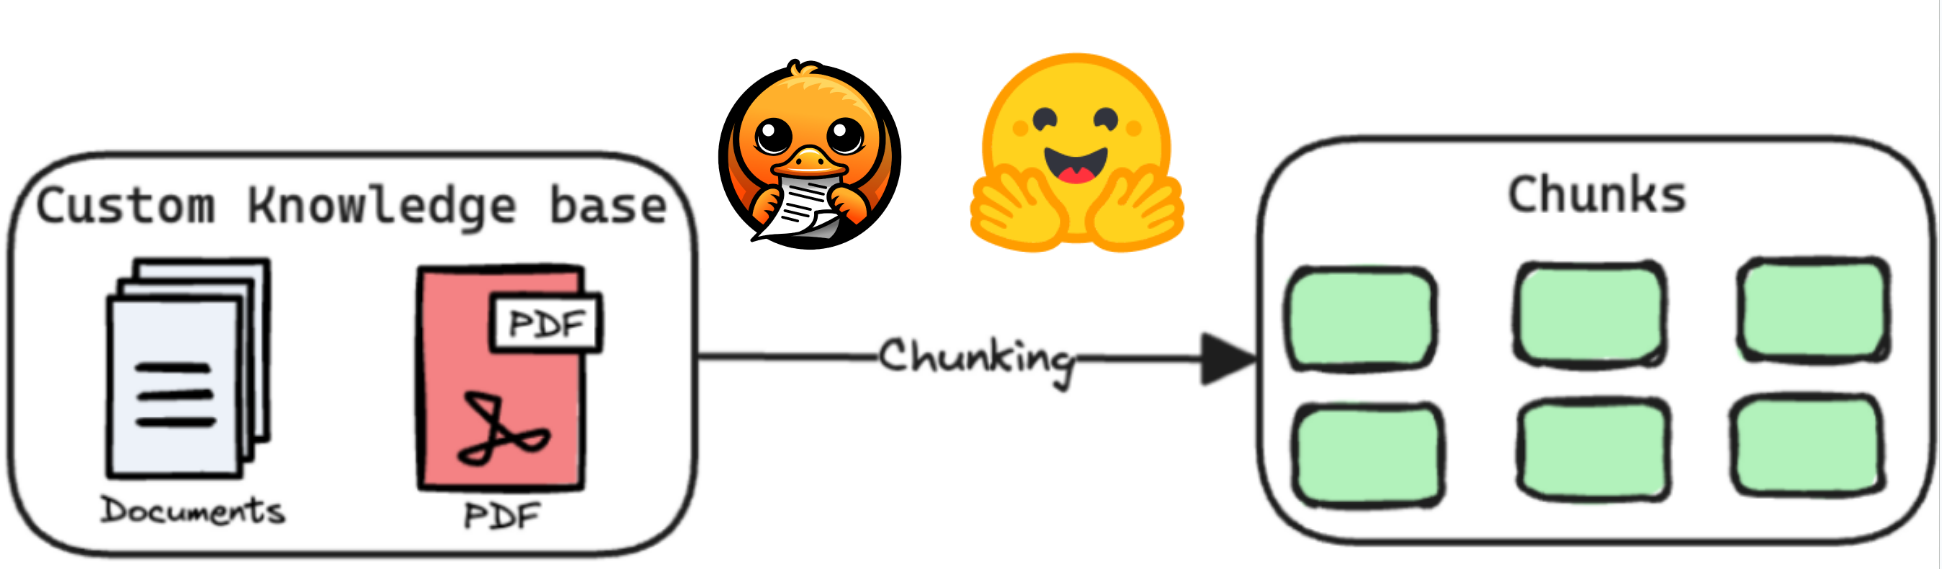

**Why Store Metadata:**
- `filename`: Human-readable reference for search results
- `source`: Full path needed for re-processing or verification
- `chunk_index`: Reconstruct document order if needed
- `timestamp`: Track when data was last updated

In [7]:
# Check chunks
all_chunks

[{'text': 'I THE\' R E W R I T T E N B I B L E \' : T H E  P R O B L E M\nWITHIN the corpus of post-biblical  Jewish  literature  are a number  of texts devoted  to  retelHng  in  their  own  words  the story  of the  Bible.  These  texts  are often  treated  as  constituting  a  literary  genre,  for  which  the  tides  \'rewritten Bible\'  (Vermes, 1973, pp. 67-126) and  \'texte  continue\'  (Perrot  and  Bogaert, 1976, pp. 22-8) have been proposed. This type of composition  has been  briefly defined as \'a  narrative that follows Scripture but includes a substantial  amount of  supplements  and  interpretative  developments\'  (Vermes  in  Schiirer, 1986, p. 326). Much  has  been  written  about  the content  of these  texts -  its  relation\xad ship to Scripture and to the midrashic  tradition as a whole. Litde, however, has been  said  about  their  formal  literary  characteristics.  The  supposed  genre  as such  remains  ill-defined.  No  one  has  yet  established the  difTere

## Section 4: Generate Embeddings and Populate Database


**What Happens:**
1. Load sentence-transformer model (~80MB for all-MiniLM-L6-v2)
2. Generate embeddings for ALL chunks in parallel
3. Create unique IDs for each chunk
4. Convert numpy embeddings to Python lists
5. Prepare tuples matching database schema
7. Insert/replace all data in one bulk operation
8. Query final count to confirm storage
9. Close database connection

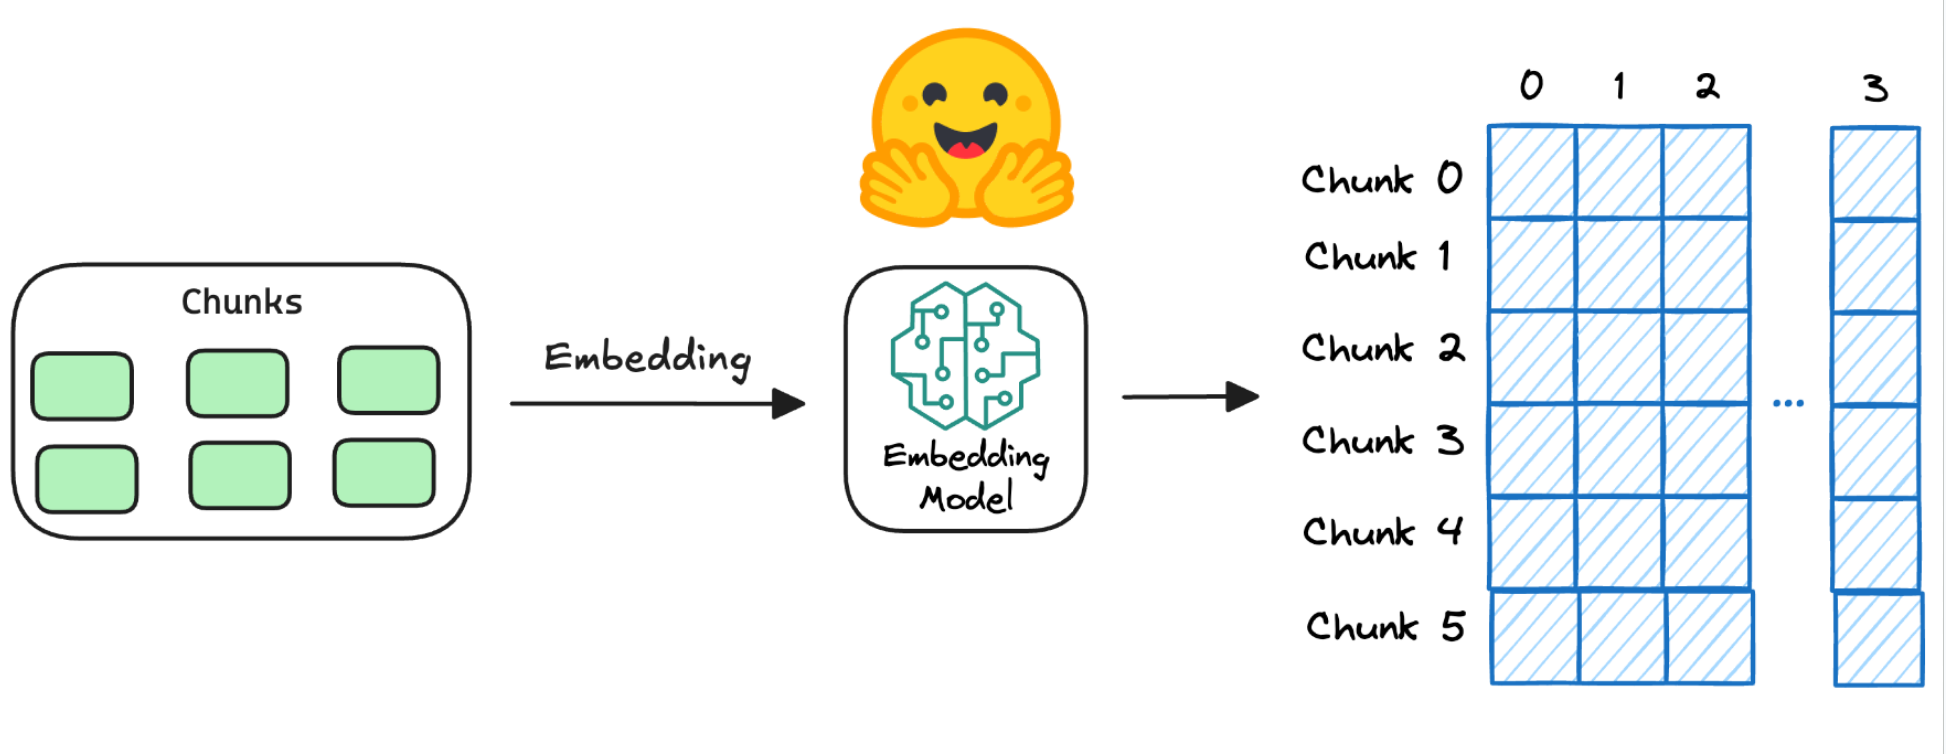

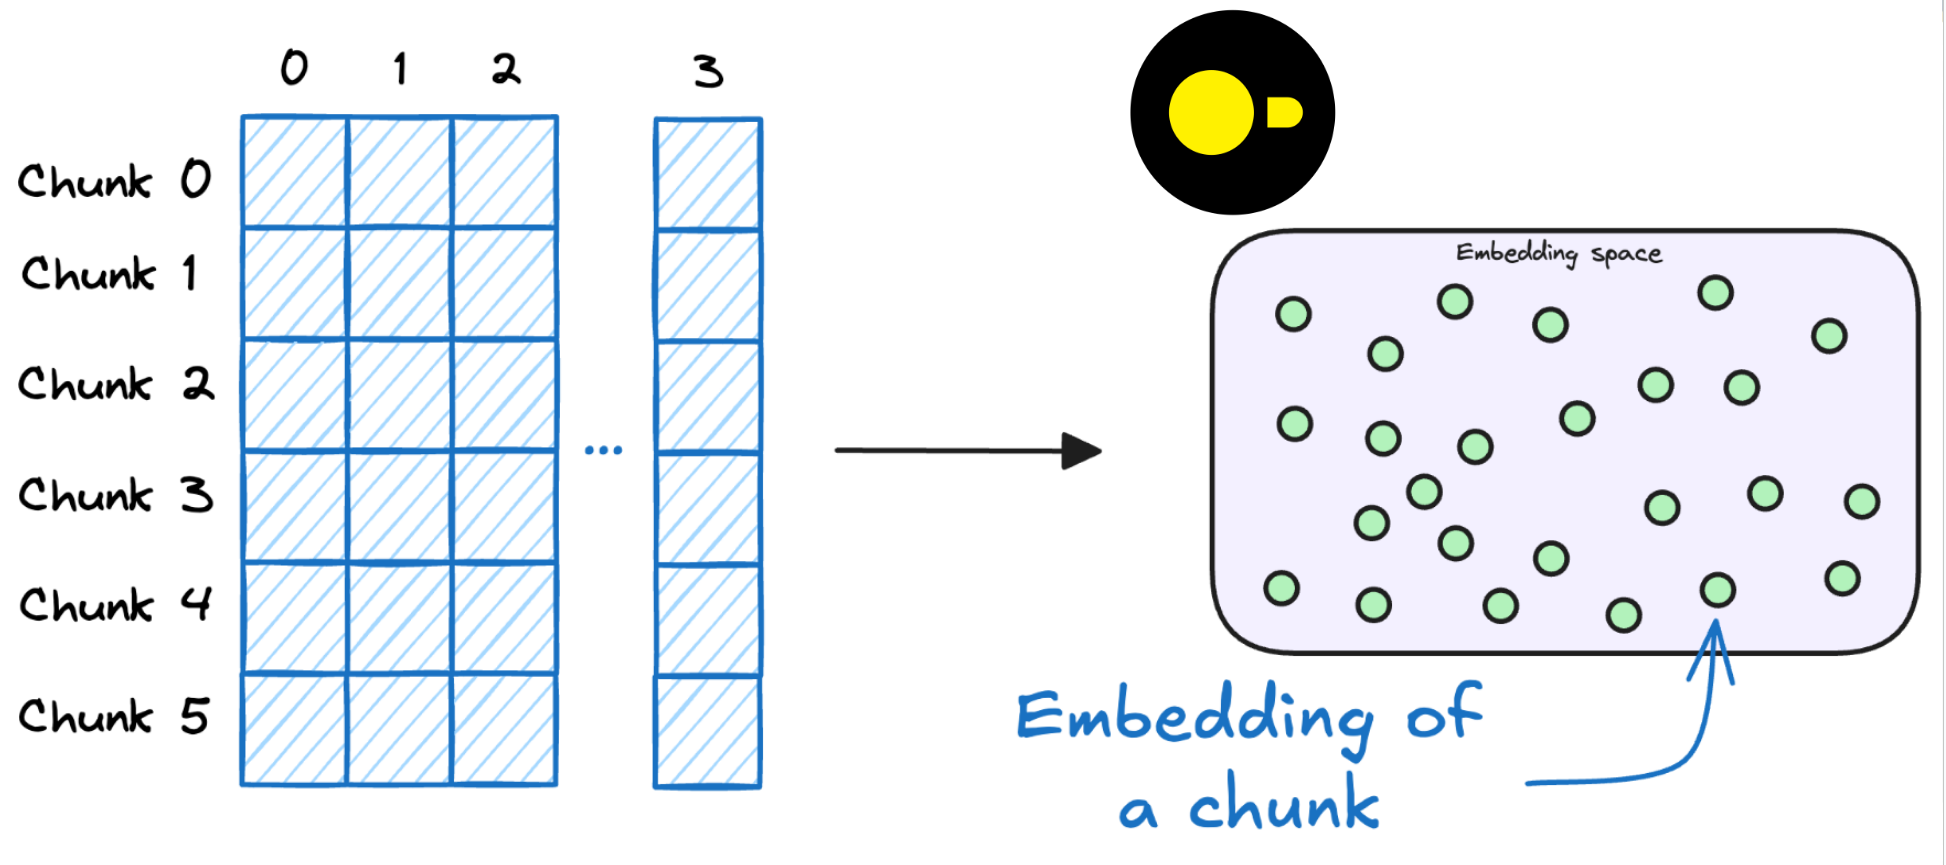

In [8]:
# Load embedding model
print(f"Loading embedding model: {EMBEDDING_MODEL}...")
embedding_model = SentenceTransformer(EMBEDDING_MODEL)

# Generate embeddings for all chunks at once
print(f"Generating embeddings for {len(all_chunks)} chunks...")
texts = [chunk["text"] for chunk in all_chunks]
embeddings = embedding_model.encode(
    texts,
    show_progress_bar=True,        # Show progress for large collections
    convert_to_numpy=True           # Return as numpy arrays
)

# Prepare data for insertion
print(f"Storing chunks in DuckDB...\n")
data_to_insert = []
for i, chunk in enumerate(all_chunks):
    # Create unique ID: filename + chunk index
    chunk_id = f"{chunk['filename']}_chunk_{chunk['chunk_index']}"

    # Convert numpy array to Python list for DuckDB
    embedding_list = embeddings[i].tolist()

    # Tuple matching table schema order
    data_to_insert.append((
        chunk_id,
        chunk["text"],
        embedding_list,
        chunk["filename"],
        chunk["source"],
        chunk["chunk_index"],
        chunk["timestamp"]
    ))

# Insert or replace existing chunks with same ID
# OR REPLACE overwrites any existing rows with matching primary key
conn.executemany(f"""
    INSERT OR REPLACE INTO {COLLECTION_NAME}
    (id, text, embedding, filename, source, chunk_index, timestamp)
    VALUES (?, ?, ?, ?, ?, ?, ?)
""", data_to_insert)

# Get final count from database
total_count = conn.execute(f"SELECT COUNT(*) FROM {COLLECTION_NAME}").fetchone()[0]

print(f"Done! Stored {len(all_chunks)} chunks.")
print(f"Table now has {total_count} total chunks")

# Close database connection
conn.close()

Loading embedding model: all-MiniLM-L6-v2...
Generating embeddings for 65 chunks...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Storing chunks in DuckDB...

Done! Stored 65 chunks.
Table now has 65 total chunks
